<h1 align="center">  Credit risk project</h1> <br>
<img src="lendclub.png"><br><br>



Lending club has a simple set of rules for determining risky loans 

Want to be better at determining the risk of a loan, and grade it more approprately

The CEO has heard of ML


In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 768,
        'scroll': True,
})

{'width': 1920, 'height': 768, 'scroll': True}

### Task

Based on the information we have **at the time of loan application**, build a Machine Learning model that **classifies** of the loan will be paid back in time or not. 

The model will replace the old model and be used to calculate interest rate, grading and potential manual processing


### Outline of the project

Data filtering and feature selection

Data visualization

Prepare data for modeling

Modeling
* Linear model etc
* Boosting models

* Enrich with NLP

"Putting it into production" 


<h1 align="center"> Lending Club Loan ML project </h1> <br>


## Company Information - Lending Club 
peer to peer loans (consumer to consumer)



<img src="http://echeck.org/wp-content/uploads/2016/12/Showing-how-the-lending-club-works-and-makes-money-1.png"><br><br>

Lending Club is a  peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take (the borrowers credit score). Lending Club provides the "bridge" between investors and borrowers. For more basic information about the company please check out the wikipedia article about the company. <br><br>





In [2]:
!pip install pandas scikit-learn seaborn matplotlib nltk lightgbm xgboost shap RISE imblearn



## Data preparation and visualization
* Ingest data, and remove unwanted columns from data
* Create label for binary classifcation
* Visualize data 



# Import libraries

In [3]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle


%matplotlib inline

<img src="data.png"><br><br>

# Read data


* type: CSV
* size 450 MB
* rows: 887000
* potential fetures: 75



In [4]:
#parse csv
df = pd.read_csv('data/loan.csv', low_memory=False)

#show data
print(f"Data has {df.shape[0]} rows")
df.head() 

Data has 887379 rows


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

# filter data

<img src="columns2.png"><br><br>

In [6]:
cols = pd.read_csv("Data_desc.csv") # Read in column definition csv

column_definition = cols.loc[cols["Keep"] == 'Yes'] # only keep chosen columns 

# list all numeric columns
numeric_cols = (column_definition["Column name"]
                [column_definition["Type"]=="Numeric"]) 

# list all categorical columns
categorical_cols = (column_definition["Column name"]
                    [column_definition["Type"]=="Categorical"]) 
# list all text columns
text_cols = (column_definition["Column name"]
             [column_definition["Type"]=="Text"]) 

# filter dataframe to only include chosen columns
start_data = df[column_definition["Column name"]] 

#filter data to only include individual applications 
start_data = start_data[start_data["application_type"] == "INDIVIDUAL"].copy()

# drop unnecessary column
start_data.drop(columns=["application_type"], inplace=True)



### Show start data

In [7]:
print("""Start data has:
{} rows and 
{} columns""".format(start_data.shape[0],
                     start_data.shape[1]))


start_data.sample(20)


Start data has:
886868 rows and 
16 columns


,id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,addr_state,dti,pub_rec,total_acc
857330,39532851,30000.0,60 months,physician,8 years,MORTGAGE,140000.0,Verified,Current,NaN,credit_card,Credit card refinancing,IN,24.81,1.0,24.0
725349,50567117,16925.0,60 months,truck driver,10+ years,RENT,46000.0,Verified,Current,NaN,debt_consolidation,Debt consolidation,NY,20.61,0.0,28.0
362519,19025043,10000.0,36 months,motorclothes sales,1 year,OWN,39470.0,Not Verified,Current,NaN,credit_card,Credit card refinancing,WI,12.44,0.0,11.0
599995,60596726,12000.0,36 months,Engineering Associate,< 1 year,RENT,55000.0,Source Verified,Current,NaN,debt_consolidation,Debt consolidation,FL,24.69,0.0,26.0
707695,52949146,15000.0,60 months,rn,< 1 year,MORTGAGE,65000.0,Verified,Current,NaN,debt_consolidation,Debt consolidation,LA,17.74,0.0,20.0
124371,4115003,13200.0,60 months,maui's winrry,8 years,MORTGAGE,49000.0,Verified,Current,NaN,debt_consolidation,myloan,HI,23.88,0.0,13.0
316498,25807169,4875.0,36 months,Data entry,1 year,RENT,30000.0,Not Verified,Current,NaN,credit_card,Credit card refinancing,CA,25.28,0.0,21.0
514709,65804838,16000.0,60 months,Teacher,3 years,MORTGAGE,48800.0,Verified,Current,NaN,other,Other,GA,27.74,0.0,33.0
541099,61416057,20000.0,60 months,Specialty Operator 2,< 1 year,MORTGAGE,52000.0,Not Verified,Current,NaN,debt_consolidation,Debt consolidation,TX,16.50,0.0,28.0
811921,43096354,35000.0,60 months,COMSEC Account manager,4 years,MORTGAGE,111000.0,Source Verified,Current,NaN,debt_consolidation,Debt consolidation,MD,21.41,0.0,47.0


In [8]:
start_data.head()  

,id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,addr_state,dti,pub_rec,total_acc
0,1077501,5000.0,36 months,NaN,10+ years,RENT,24000.0,Verified,Fully Paid,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,AZ,27.65,0.0,9.0
1,1077430,2500.0,60 months,Ryder,< 1 year,RENT,30000.0,Source Verified,Charged Off,Borrower added on 12/22/11 > I plan to use t...,car,bike,GA,1.00,0.0,4.0
2,1077175,2400.0,36 months,NaN,10+ years,RENT,12252.0,Not Verified,Fully Paid,NaN,small_business,real estate business,IL,8.72,0.0,10.0
3,1076863,10000.0,36 months,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Fully Paid,Borrower added on 12/21/11 > to pay for prop...,other,personel,CA,20.00,0.0,37.0
4,1075358,3000.0,60 months,University Medical Group,1 year,RENT,80000.0,Source Verified,Current,Borrower added on 12/21/11 > I plan on combi...,other,Personal,OR,17.94,0.0,38.0


In [9]:
# counts of different loan outcomes 

start_data["loan_status"].value_counts()

Current                                                601338
Fully Paid                                             207722
Charged Off                                             45248
Late (31-120 days)                                      11589
Issued                                                   8396
In Grace Period                                          6250
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

### Determining the loans that are bad from loan_status column

In [11]:

bad_loan = ["Default", 
            "In Grace Period", 
            "Late (31-120 days)"] # label value 1

good_loan = ["Fully Paid"] # label value 0

current  = ['Current'] # remove from training data



In [12]:

start_data["bad_loan"] = -1
start_data.loc[start_data["loan_status"].isin(bad_loan), 'bad_loan'] = 1
start_data.loc[start_data["loan_status"].isin(good_loan), 'bad_loan'] = 0
start_data.loc[start_data["loan_status"].isin(current), 'bad_loan'] = np.nan
start_data.drop(columns="loan_status", inplace=True)

training_data = start_data[start_data['bad_loan'] >-1].drop("id", axis=1).reset_index(drop=True)

scoring_data = start_data[start_data['bad_loan'].isnull()].reset_index(drop=True)
ids = scoring_data["id"]
scoring_data.drop(columns="id", inplace=True)
print("Fraction of bad loans is {:f} %".format(100*np.mean(training_data["bad_loan"])))

Fraction of bad loans is 8.403739 %


### Save all open loans for later

In [13]:
scoring_data_dictionary = {"data":scoring_data, 
                "loan_ids":ids}

pickle.dump(scoring_data_dictionary, open("scoring_data.pkl", "wb"))

### Quick recap so far

Ingested the data 

Removed columns that cause information leak

Determined what is a good loan and a bad loan

constructed the label


### How many null values do we have in the data?

In [15]:
training_data.isna().sum()

loan_amnt                   0
term                        0
emp_title               11630
emp_length               8399
home_ownership              0
annual_inc                  0
verification_status         0
desc                   151884
purpose                     0
title                      11
addr_state                  0
dti                         0
pub_rec                     0
total_acc                   0
bad_loan                    0
dtype: int64

In [16]:
def fill_nans(df):
    """
    Function to fill all null values 
        numeric columns get a fill value = 0
        non-numeric columns get a fill value = Unknown
    """
    for column in df.columns:
        if column in list(numeric_cols):
            df[column]=df[column].fillna(0)
        else:
            df[column]=df[column].fillna("Unknown")
    return df


In [17]:
training_data = fill_nans(training_data)
training_data.isna().sum()

loan_amnt              0
term                   0
emp_title              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
desc                   0
purpose                0
title                  0
addr_state             0
dti                    0
pub_rec                0
total_acc              0
bad_loan               0
dtype: int64

In [18]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226780 entries, 0 to 226779
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            226780 non-null  float64
 1   term                 226780 non-null  object 
 2   emp_title            226780 non-null  object 
 3   emp_length           226780 non-null  object 
 4   home_ownership       226780 non-null  object 
 5   annual_inc           226780 non-null  float64
 6   verification_status  226780 non-null  object 
 7   desc                 226780 non-null  object 
 8   purpose              226780 non-null  object 
 9   title                226780 non-null  object 
 10  addr_state           226780 non-null  object 
 11  dti                  226780 non-null  float64
 12  pub_rec              226780 non-null  float64
 13  total_acc            226780 non-null  float64
 14  bad_loan             226780 non-null  float64
dtypes: float64(6), ob

# Visualization/exploration

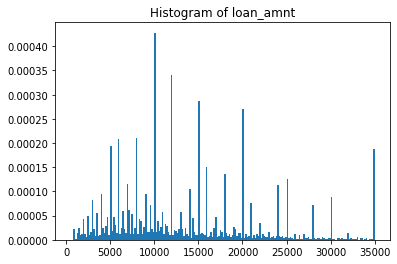

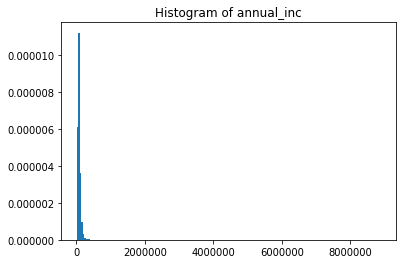

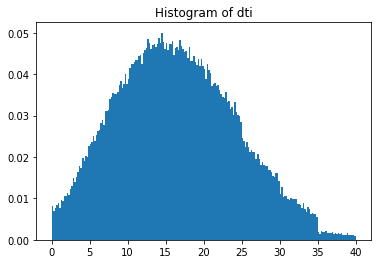

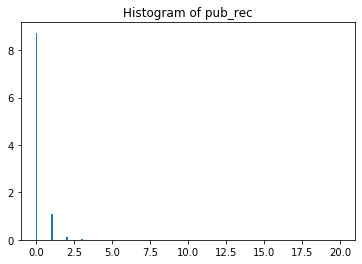

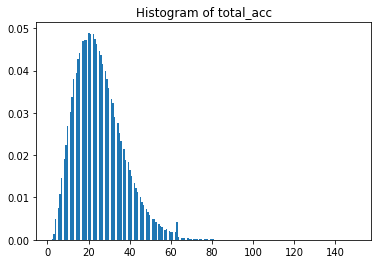

In [19]:
for column in numeric_cols:
    plt.hist(training_data[column], bins=200, density=True, histtype="stepfilled")
    plt.title("Histogram of {}".format(column))
    plt.show()
    
    

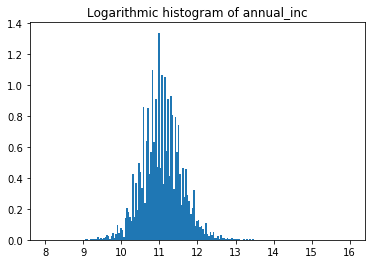

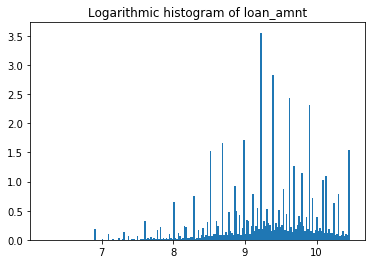

In [20]:
for column in ["annual_inc", "loan_amnt"]:
    plt.hist(np.log(training_data[column]), bins=200, density=True, histtype="stepfilled")
    plt.title("Logarithmic histogram of {}".format(column))
    plt.show()
    

### Correlation plot

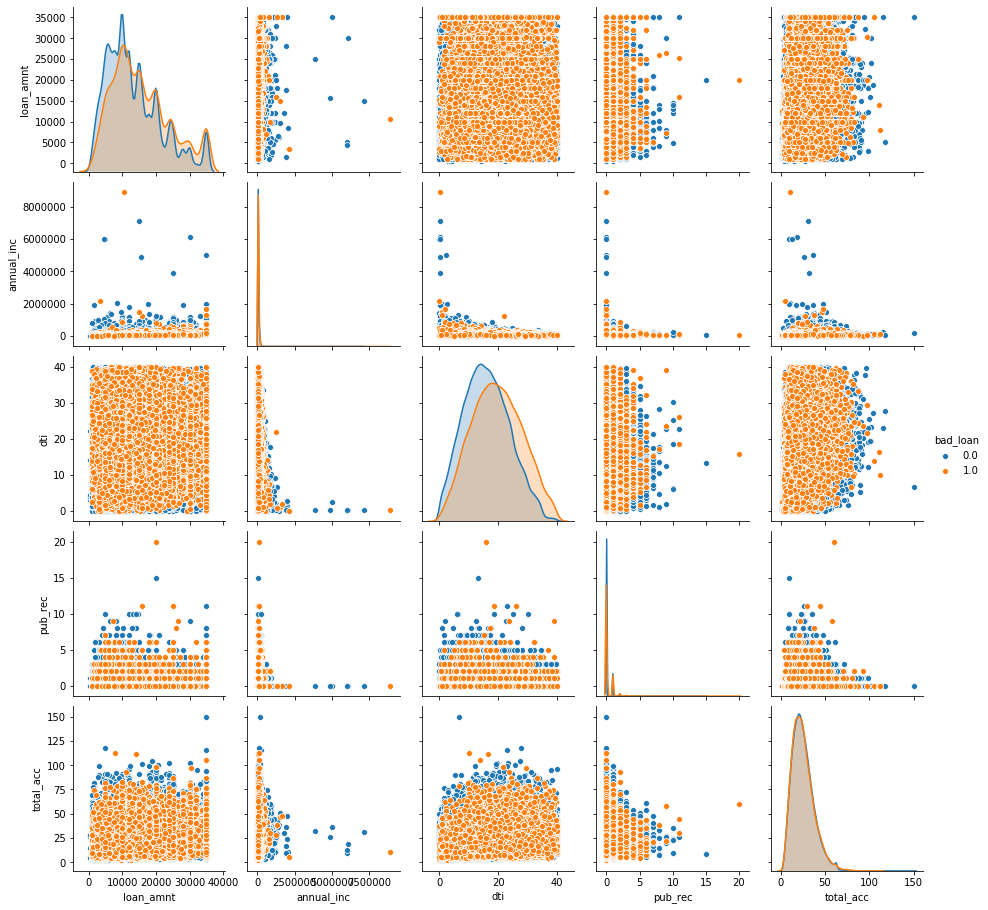

In [21]:
sns.pairplot(training_data, 
             vars=numeric_cols, 
             hue="bad_loan")
plt.show()


### Any differences between differnt categorical values?

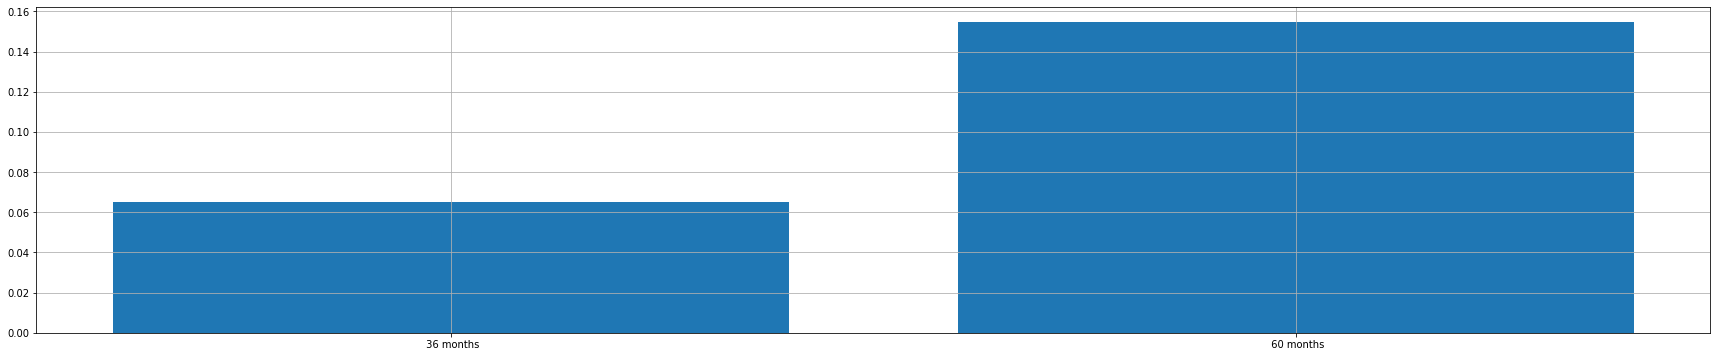

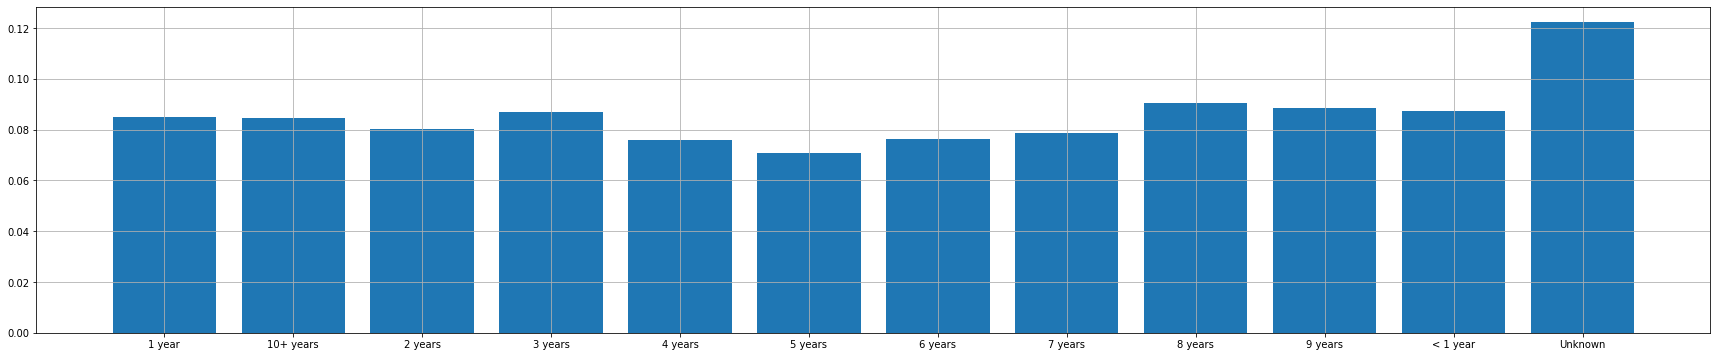

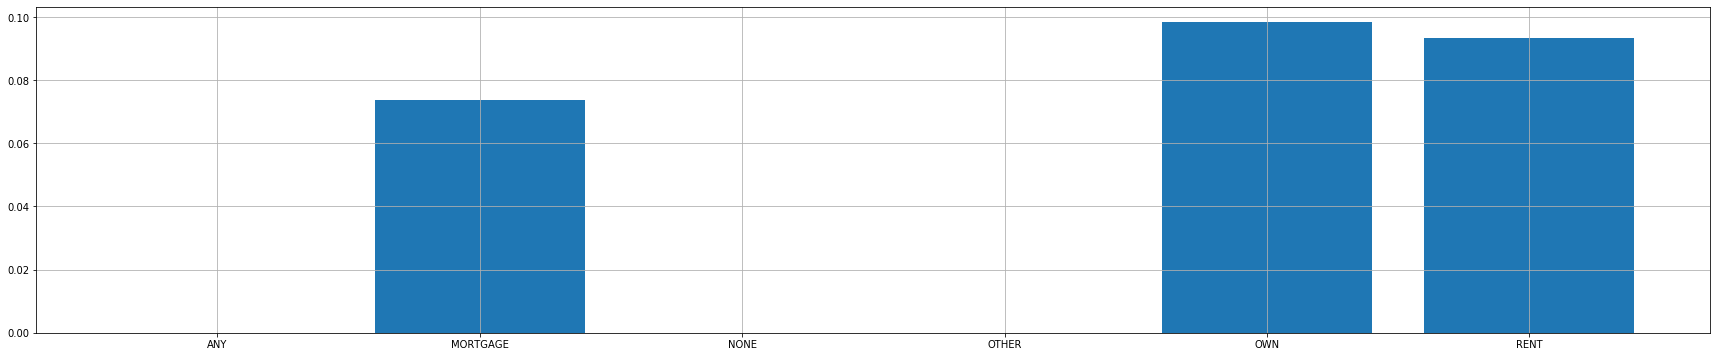

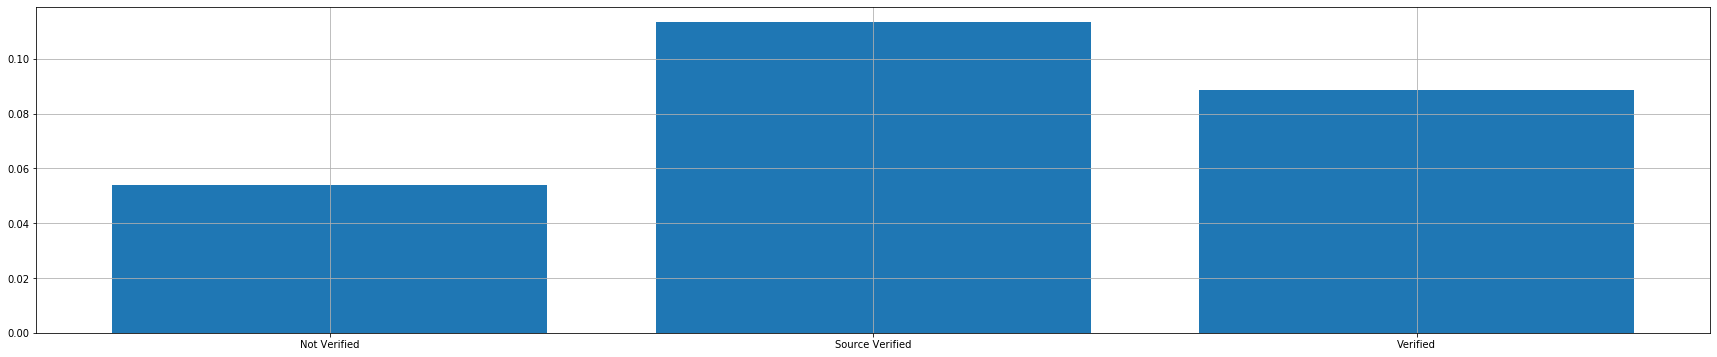

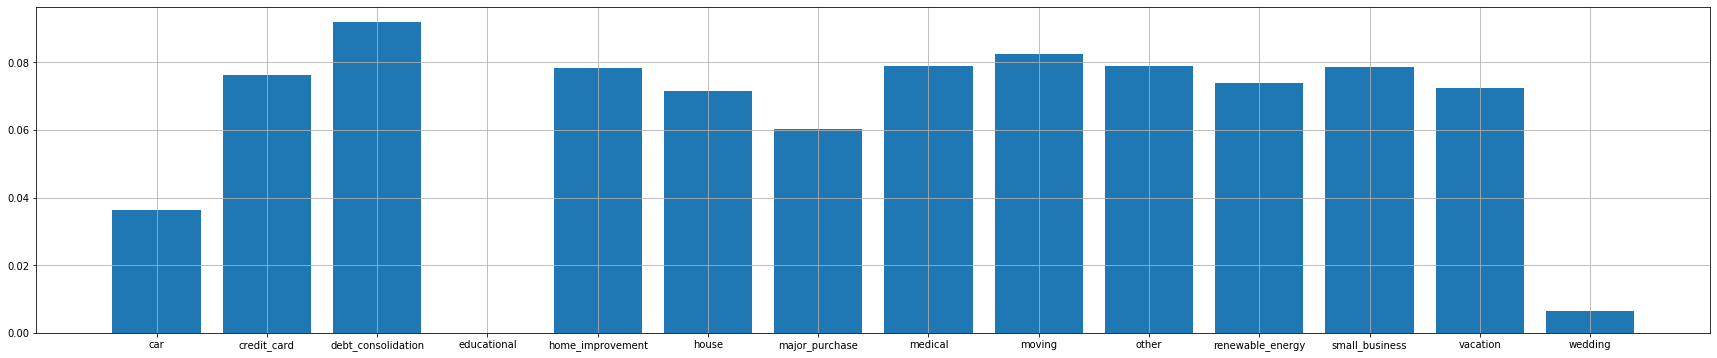

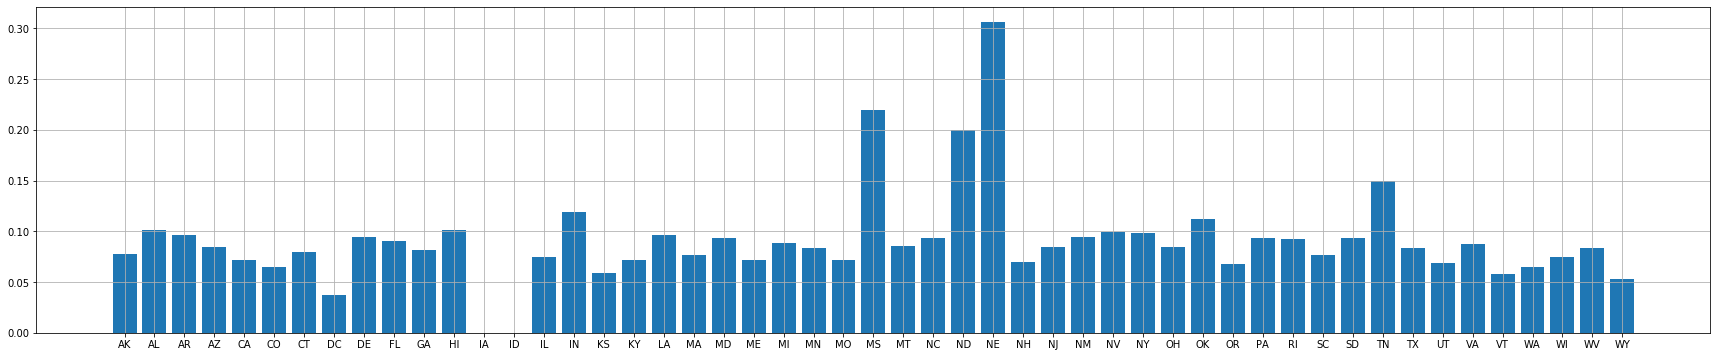

In [63]:

for column in categorical_cols:
    if column in training_data.columns.values:
        fig, ax = plt.subplots(figsize=(30,6))
        tt = training_data.groupby(column).mean()["bad_loan"]
        ax = plt.bar(tt.index, tt.values)
        plt.grid()
        plt.show()
        plt.close()
        
# training_data.groupby("purpose").count()["bad_loan"]

## Modeling

### Simple models 
* prepare data for modeling 
* Logistic regression
* Decision tree
* Naive Bayes

### Boosting models 
* xgBoost
* LightGBM

## Adding Text


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn import metrics as mm


def clean_categorical_values(df, rx='[^0-9a-zA-Z]+', rep = "_"):
        df = df.replace(
            rx, rep, regex=True).astype(str)
        return df


class DenseTfidfVectorizer(TfidfVectorizer):

    def transform(self, raw_documents, copy=True, id_str=''):
        X = super().transform(raw_documents, copy=copy)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        df.columns = [id_str + x.replace(' ', '_') for x in df.columns.values]
        return df

    def fit_transform(self, raw_documents, y=None, id_str=''):
        X = super().fit_transform(raw_documents, y=y)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        df.columns = [id_str + x.replace(' ', '_') for x in df.columns.values]
        return df
    

def OneHotEncodeDF(df):

    ohe = OneHotEncoder(
        sparse=False, handle_unknown='ignore')
    
    arr_cat_ohe = ohe.fit_transform(df)
   
    cat_ohe_cols = ohe.get_feature_names(
        df.columns.values)
    
    df_cat = pd.DataFrame(arr_cat_ohe, columns=cat_ohe_cols)
    
    return df_cat, ohe

def ScalerDF(df):
    numeric_scaler = StandardScaler()
    np_n = numeric_scaler.fit_transform(df)
    df_n = pd.DataFrame(np_n, columns=df.columns)
    return df_n



def undersample(df, col = "bad_loan", ratio = 1):
    rus = RandomUnderSampler( sampling_strategy=ratio)
    X_rus, y_rus = rus.fit_resample(training_data.drop(col, axis=1), training_data[col])

    X_rus[col] = y_rus
    return X_rus

def precision_recall_curve_with_threshod(y_test, probs, title='title', save=False):
    average_precision = mm.average_precision_score(y_test, probs)
    precision, recall, thresholds = mm.precision_recall_curve(y_test, probs)
    thresholds=np.around(thresholds,decimals=2)
    step_kwargs = {}
    plt.step(recall, precision, color="b",alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)
    idxs=np.linspace(0,len(thresholds)-1,20,dtype=int)
    for idx in idxs:
        plt.scatter(recall[idx],precision[idx],color='r',s=5)
        plt.text(recall[idx],precision[idx],str(thresholds[idx]))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if title:
        plt.title(title + f' AP={average_precision}')
    
    if save:
        plt.savefig(f'{title}.png',bbox_inches='tight')
    plt.show() 
    


def confusion_matrix_plot(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()



def evaluate_model(model, X, y, title="Model"):
    if ("LogisticRegression" in str(type(model)) or
       "DecisionTreeClassifier" in str(type(model)) or
       "GaussianNB" in str(type(model))):
        
        y_pred=model.predict_proba(X)[:,1]
    else:
        y_pred = model.predict(X)

    print(mm.classification_report(y, np.round(y_pred)))

    fpr, tpr, thresholds = mm.roc_curve(y, y_pred)
    roc_auc = mm.roc_auc_score(y, y_pred)

    plt.title('Receiver Operating Characteristic for {}'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   
    confusion_matrix_plot(y,np.round(y_pred))
    precision_recall_curve_with_threshod(y, y_pred, title=title, save=False)
    
    

# Modeling 

In [24]:
categorical_features = training_data[categorical_cols[categorical_cols.isin(training_data.columns)]]
numeric_features = training_data[numeric_cols[numeric_cols.isin(training_data.columns)]].copy()
categorical_features = clean_categorical_values(categorical_features)
y = training_data["bad_loan"]

### Prepare all features so they are numeric

In [25]:

# Data preparation for linear model
# Categorical features has to be converted to numeric - e.g. OneHot encoding 


categorical_features_ohe, OHE = OneHotEncodeDF(categorical_features)

numeric_features_scaled = ScalerDF(numeric_features)

X = numeric_features_scaled.reset_index(drop=True).merge(
        categorical_features_ohe.reset_index(drop=True), left_index=True, right_index=True)
print("X dimension: {}, y dimension: {}".format(X.shape, y.shape))

X.head()

X dimension: (226780, 93), y dimension: (226780,)


,loan_amnt,annual_inc,dti,pub_rec,total_acc,term__36_months,term__60_months,emp_length_10_years,emp_length_1_year,emp_length_2_years,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,-1.051208,-0.814703,1.433344,-0.331702,-1.372842,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.371133,-1.006258,-0.986509,-0.331702,-1.288221,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.435968,-0.403809,0.455432,-0.331702,0.996536,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.051208,-0.619039,-0.669487,-0.331702,-1.118980,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.297304,-0.423375,-1.417302,-0.331702,-1.795945,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split data & undersampling of training data

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rus = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = rus.fit_resample(X_train, y_train)



## Train and evaluate Linear model 

In [27]:
linear_model = LogisticRegression(max_iter=500)
linear_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       0.95      0.67      0.79     68538
         1.0       0.15      0.63      0.24      6300

    accuracy                           0.67     74838
   macro avg       0.55      0.65      0.51     74838
weighted avg       0.88      0.67      0.74     74838



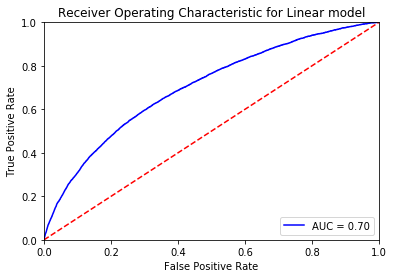

Confusion matrix:
 [[45833 22705]
 [ 2351  3949]]


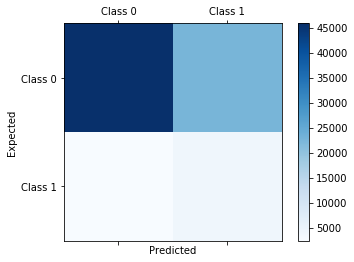

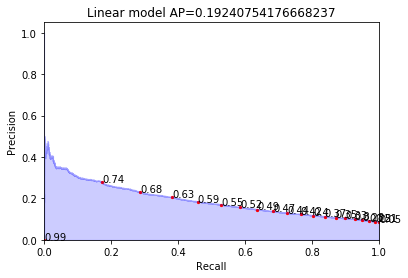

In [28]:
evaluate_model(linear_model, X_test, y_test, "Linear model")


## Decision tree

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
simple_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=1000)

simple_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

         0.0       0.95      0.67      0.79     68538
         1.0       0.14      0.59      0.23      6300

    accuracy                           0.66     74838
   macro avg       0.54      0.63      0.51     74838
weighted avg       0.88      0.66      0.74     74838



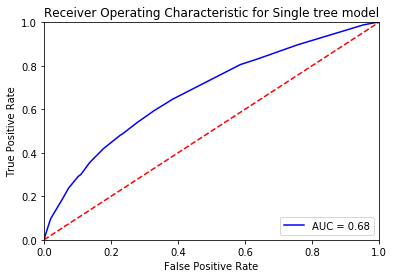

Confusion matrix:
 [[45994 22544]
 [ 2556  3744]]


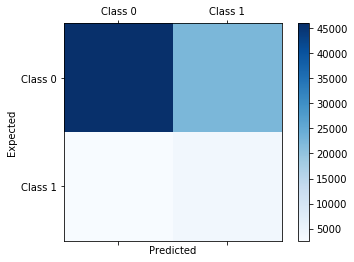

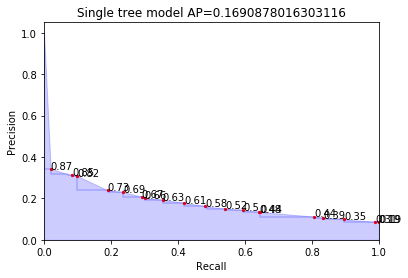

In [30]:
evaluate_model(simple_tree, X_test, y_test, "Single tree model")

### Plot Decision tree

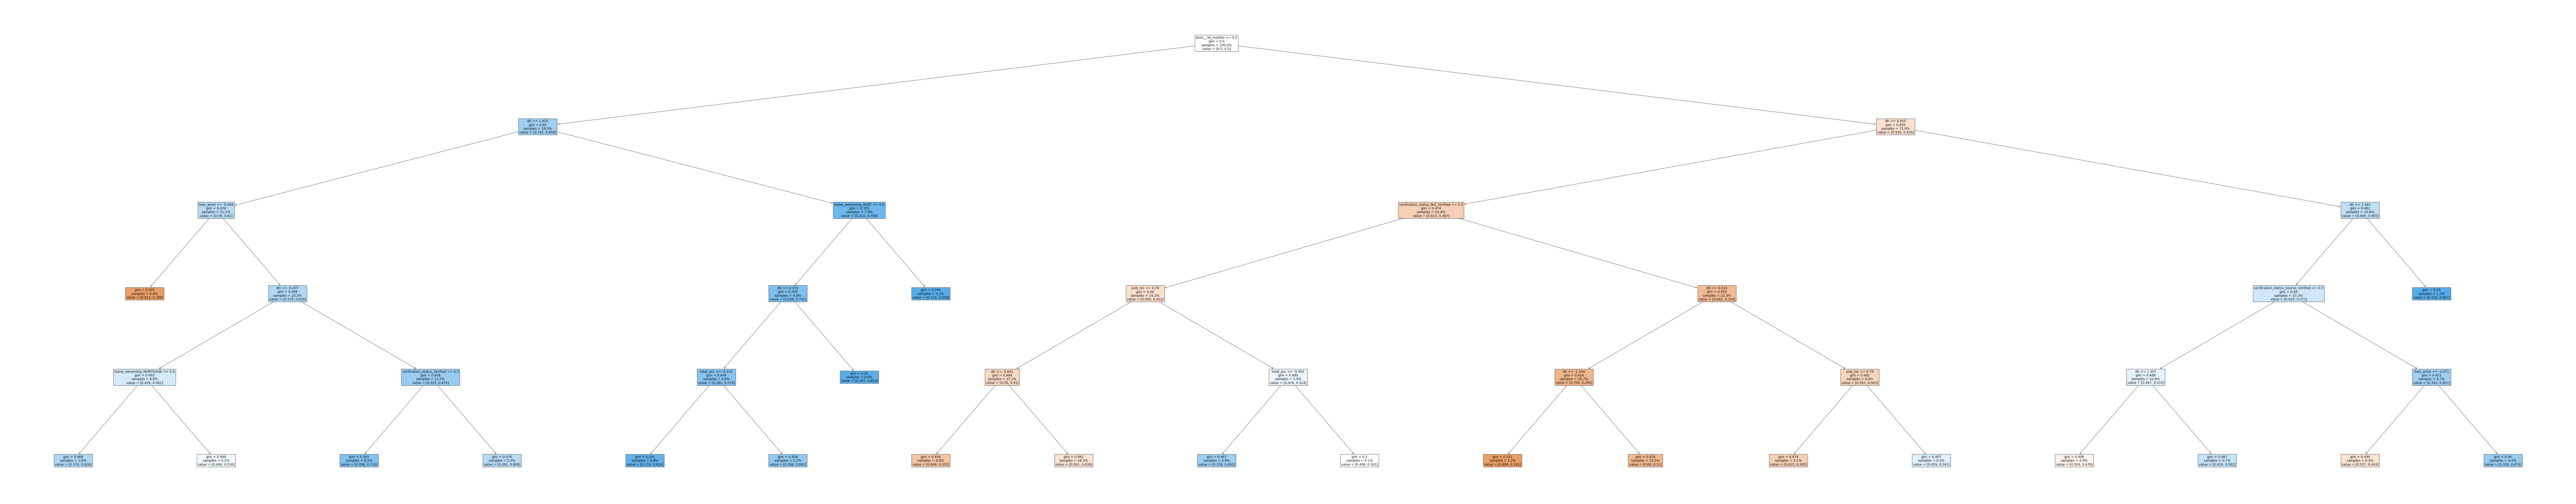

In [31]:
plt.figure(figsize=(200,40))
plt.rcParams['axes.facecolor'] = 'white'
plot_tree(simple_tree, filled=True, feature_names=X_train.columns.values, fontsize=14, proportion=True)
plt.savefig("tree.png", transparent=False)

## Naive bayes 

In [32]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)



GaussianNB(priors=None, var_smoothing=1e-09)

              precision    recall  f1-score   support

         0.0       0.96      0.05      0.10     68538
         1.0       0.09      0.98      0.16      6300

    accuracy                           0.13     74838
   macro avg       0.52      0.51      0.13     74838
weighted avg       0.89      0.13      0.10     74838



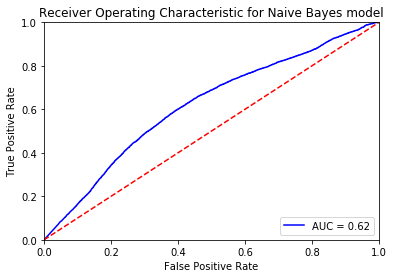

Confusion matrix:
 [[ 3435 65103]
 [  146  6154]]


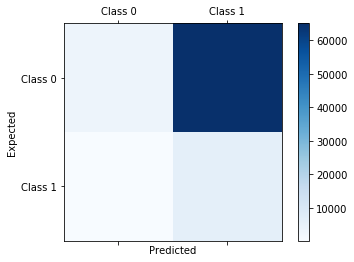

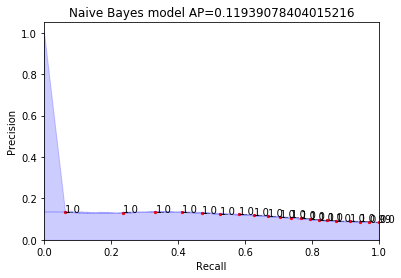

In [33]:
evaluate_model(naive_bayes, X_test, y_test, "Naive Bayes model")

## XGBoost

In [34]:
import xgboost as xgb

params = {"objective":"binary:logistic",
         "eval_metric":"auc",
          "colsample_bytree":0.8}



train_dmatrix = xgb.DMatrix(X_train,
                            label=np.asarray(y_train))

test_dmatrix = xgb.DMatrix(X_test,
                            label=np.asarray(y_test))

xgb_model = xgb.train(params, train_dmatrix,
                      num_boost_round=400,
                      early_stopping_rounds=10,
                      verbose_eval=10,
                      evals=[(train_dmatrix, 'train'),
                             (test_dmatrix, 'test')])

[0]	train-auc:0.693772	test-auc:0.67643
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[10]	train-auc:0.742487	test-auc:0.706155
[20]	train-auc:0.760318	test-auc:0.70871
[30]	train-auc:0.769897	test-auc:0.708851
Stopping. Best iteration:
[23]	train-auc:0.763371	test-auc:0.709381



              precision    recall  f1-score   support

         0.0       0.95      0.68      0.79     68538
         1.0       0.15      0.62      0.24      6300

    accuracy                           0.68     74838
   macro avg       0.55      0.65      0.52     74838
weighted avg       0.88      0.68      0.75     74838



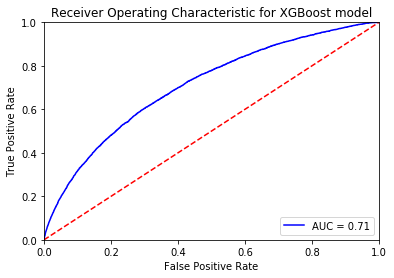

Confusion matrix:
 [[46767 21771]
 [ 2388  3912]]


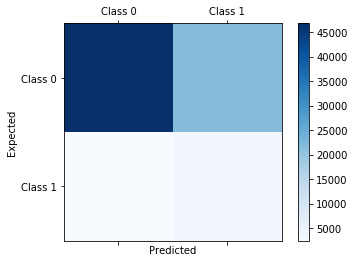

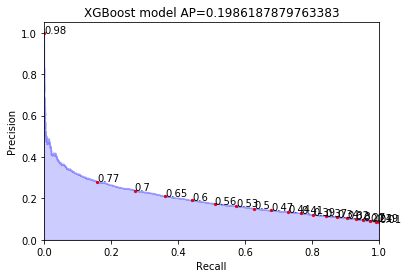

In [35]:
evaluate_model(xgb_model, test_dmatrix, y_test, "XGBoost model")

### xgBoost feature importance

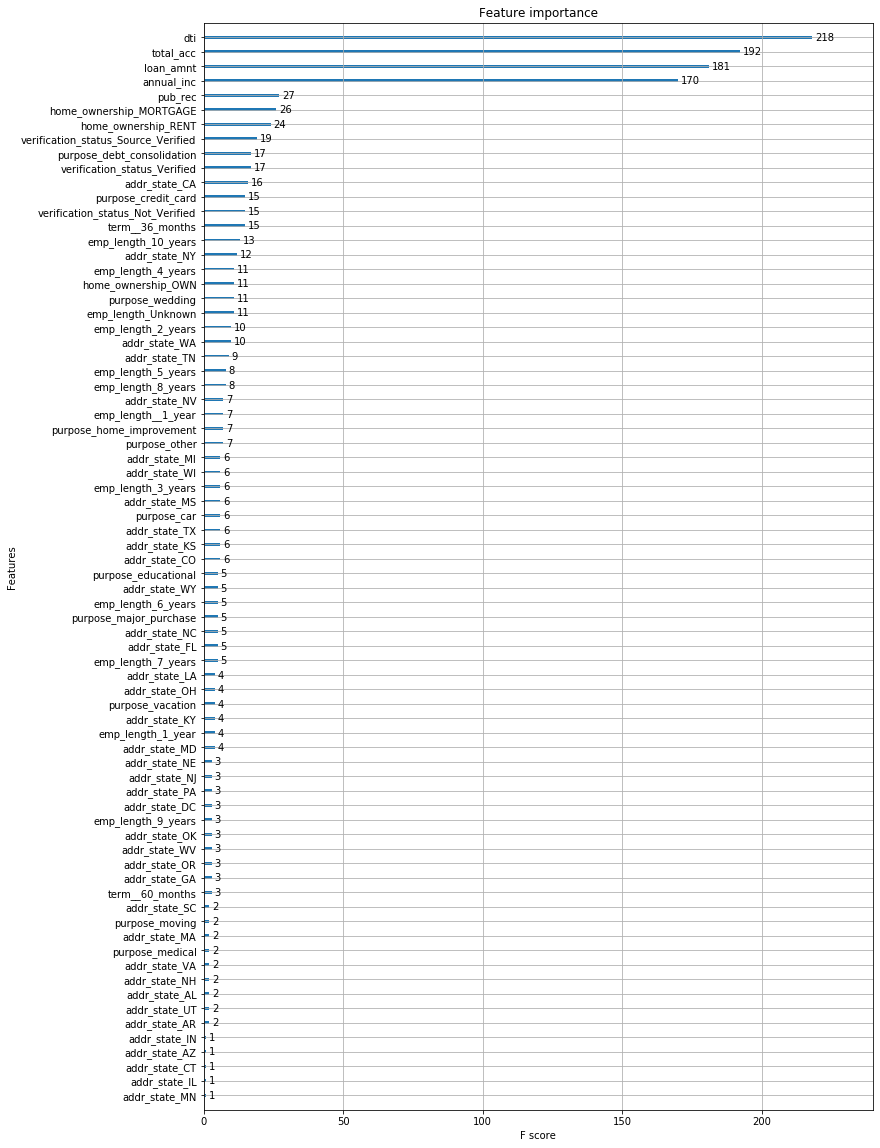

In [36]:
from xgboost import plot_importance
def xgb_importance(booster, figsize, **kwargs):
    """plot xgb importance"""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
  
xgb_importance(xgb_model, (12,20))

### SHAP values - feature importance for certain cases

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


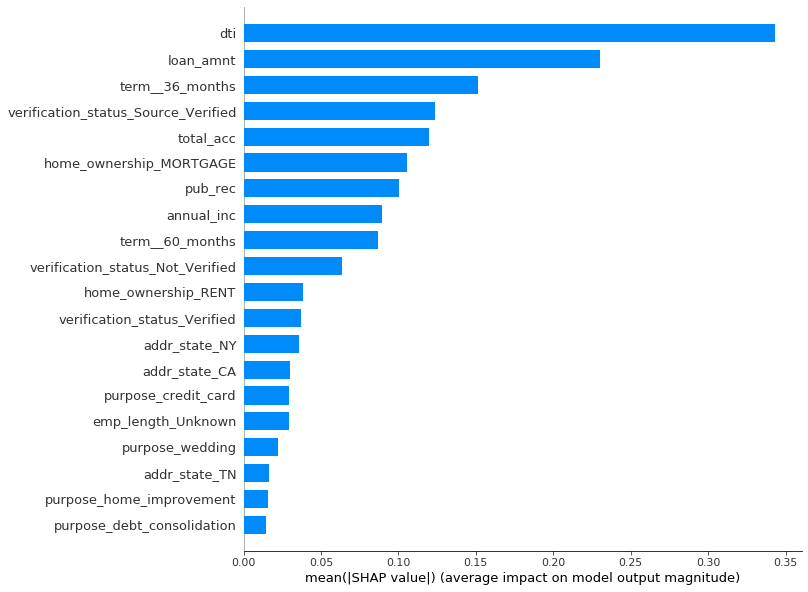

In [37]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,10), max_display=20)

### Prepare data for lightGBM

In [38]:



X = numeric_features.reset_index(drop=True).merge(
        categorical_features.reset_index(drop=True), left_index=True, right_index=True)

X.iloc[:,X.columns.isin(categorical_cols)] = X.iloc[:,X.columns.isin(categorical_cols)].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rus = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_train.head()

,loan_amnt,annual_inc,dti,pub_rec,total_acc,term,emp_length,home_ownership,verification_status,purpose,addr_state
0,9325.0,45000.0,16.21,0.0,18.0,_36_months,1_year,MORTGAGE,Not_Verified,debt_consolidation,CA
1,2000.0,50000.0,22.80,0.0,30.0,_36_months,10_years,MORTGAGE,Not_Verified,home_improvement,CO
2,4000.0,95004.0,33.67,0.0,50.0,_36_months,10_years,MORTGAGE,Verified,car,GA
3,3000.0,41600.0,18.95,0.0,14.0,_36_months,2_years,MORTGAGE,Not_Verified,major_purchase,OK
4,5000.0,25500.0,17.41,0.0,20.0,_36_months,5_years,RENT,Not_Verified,debt_consolidation,NJ


# LightGBM


In [39]:
import lightgbm as lgb
params = {"objective": "binary",
          "learning_rate":0.01,
         "colsample_bytree":0.8,
         "metric": "auc"}
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

lgbmodel = lgb.train(
    params,
    d_train,
    400,
    valid_sets=[d_train, d_test],
    early_stopping_rounds=10,
    verbose_eval=10)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.709693	valid_1's auc: 0.693133
[20]	training's auc: 0.713805	valid_1's auc: 0.696216
[30]	training's auc: 0.715175	valid_1's auc: 0.696753
[40]	training's auc: 0.717328	valid_1's auc: 0.696926
[50]	training's auc: 0.719181	valid_1's auc: 0.697732
[60]	training's auc: 0.720824	valid_1's auc: 0.698375
[70]	training's auc: 0.722106	valid_1's auc: 0.698936
[80]	training's auc: 0.72311	valid_1's auc: 0.699374
[90]	training's auc: 0.725288	valid_1's auc: 0.700334
[100]	training's auc: 0.726671	valid_1's auc: 0.700755
[110]	training's auc: 0.727823	valid_1's auc: 0.701342
[120]	training's auc: 0.729231	valid_1's auc: 0.701899
[130]	training's auc: 0.730392	valid_1's auc: 0.702426
[140]	training's auc: 0.731544	valid_1's auc: 0.702887
[150]	training's auc: 0.732893	valid_1's auc: 0.703455
[160]	training's auc: 0.734195	valid_1's auc: 0.703849
[170]	training's auc: 0.735429	valid_1's auc: 0.704362
[180]	training

              precision    recall  f1-score   support

         0.0       0.95      0.68      0.79     68538
         1.0       0.15      0.63      0.24      6300

    accuracy                           0.67     74838
   macro avg       0.55      0.65      0.52     74838
weighted avg       0.88      0.67      0.75     74838



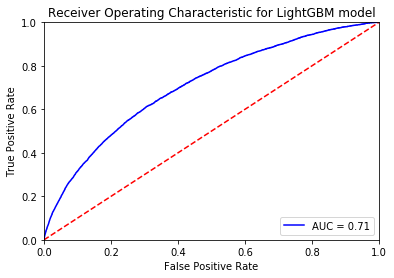

Confusion matrix:
 [[46424 22114]
 [ 2362  3938]]


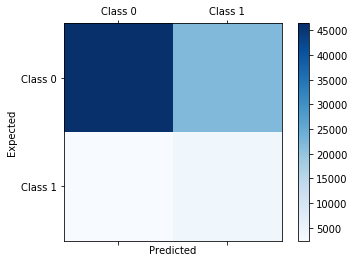

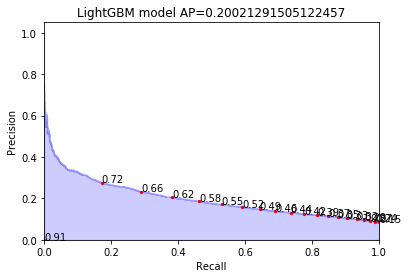

In [40]:
evaluate_model(lgbmodel, X_test, y_test, "LightGBM model")

### SHAP Values for LightGBM

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


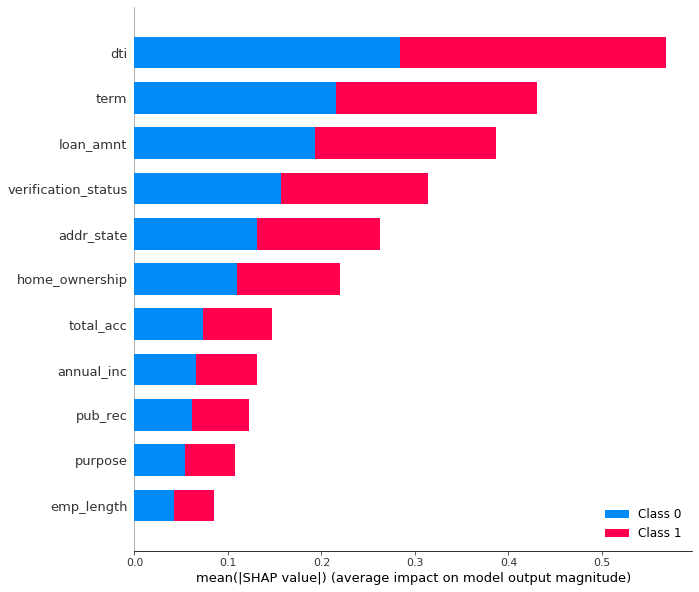

In [41]:
shap.initjs()
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,10), max_display=20)

### Now we have

* tested some diffent models (linear, trees, xgboost, lightgbm)
* we have concluded that a boosing model probably is best 
* looked into what features has the most predictive power

# Adding text data

Including text data can be done in many ways. But the common ground is to convert text to numbers.

In this case we use Term Frequency representation 





    +-------+---------------------+
    |Product| Description         |
    +-------+---------------------+
    |Prod A |Green apple          |
    +-------+---------------------+
    |Prod B |Pink fish            |
    +-------+---------------------+
    |Prod C |Green banana         |
    +-------+---------------------+
                  |
                  v
    
    |Product| green  | apple | pink | fish | banana  |
    +-------+--------+-------+------+------+---------+
    |Prod A |   1    |   1   |  0   |  0   |   0     |
    +-------+--------+-------+------+------+---------+
    |Prod B |   0    |   0   |  1   |  1   |   0     |
    +-------+--------+-------+------+------+---------+
    |Prod C |   1    |   0   |  0   |  0   |   1     |
    +-------+--------+-------+------+------+---------+

### Prepare text field, remove common words (=stop words)

In [42]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english') + ["br", "unknown", "added", "borrower"])

textfield_1 = training_data["desc"] + ' ' + training_data["title"]
textfield_2 = training_data["emp_title"]

textfield_1 = clean_categorical_values(textfield_1, rep=' ', rx='[^a-zA-Z]+')
textfield_2 = clean_categorical_values(textfield_2, rep=' ', rx='[^a-zA-Z]+')
stopWords

[nltk_data] Downloading package stopwords to /home/gurra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'added',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'borrower',
 'both',
 'br',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves'

In [43]:
print(textfield_1.sample(20))

156650                           Unknown Debt consolidation
39702                              Unknown Road to recovery
107240                           Unknown Debt consolidation
60002      Borrower added on To pay off credit card debt...
53799                       Unknown Credit card refinancing
218089                           Unknown Debt consolidation
121001                        Unknown Safari Kenya Vacation
22034                            Unknown debt consolidation
48381                              Unknown Home Improvement
141068                             Unknown Home improvement
43456                                   Unknown Sister Debt
43381                                 Unknown credit cards 
81951      Borrower added on Debt Consolidation br Debt ...
222105                      Unknown Credit card refinancing
167593                           Unknown Debt consolidation
21175      Borrower added on Home Improvements amp Debt ...
182643     Borrower added on I have seve

In [44]:
print(textfield_2.sample(20))

14211                               PUSD
129343                      e net motors
58103                    Azzurro HD LLC 
162750                   forklift driver
196510              Admissions Counselor
166053                   Program Manager
84923                    Ernst Young LLP
125924                          US Govt 
28791              US Xpress Enterprises
76337                 UnitedHealth Group
121005                               MGH
222998                           Unknown
173146                           Unknown
124883    Dyer garofalo mann and schultz
221385                               LPN
87677                         Pfizer inc
40465                   Senior Developer
161361               Director Of Nursing
152845          Senior Actuarial Analyst
66740               johnson funeral home
Name: emp_title, dtype: object


In [45]:
tf1 = DenseTfidfVectorizer(max_features=200, max_df=0.3, stop_words=stopWords, 
                          use_idf=False, binary=True, norm=None, ngram_range=(1,5))

df_text1 = tf1.fit_transform(textfield_1, id_str="Description_include_")
tf2 = DenseTfidfVectorizer(max_features=200, max_df=0.3, stop_words=stopWords, 
                          use_idf=False, binary=True, norm=None, ngram_range=(1,5))

df_text2 = tf2.fit_transform(textfield_2, id_str="Job_title_include_")



In [46]:
df_text2.head()

,Job_title_include_account,Job_title_include_account_manager,Job_title_include_accountant,Job_title_include_accounting,Job_title_include_admin,Job_title_include_administration,Job_title_include_administrative,Job_title_include_administrative_assistant,Job_title_include_administrator,Job_title_include_advisor,...,Job_title_include_usa,Job_title_include_valley,Job_title_include_vice,Job_title_include_vice_president,Job_title_include_vp,Job_title_include_warehouse,Job_title_include_wells,Job_title_include_wells_fargo,Job_title_include_worker,Job_title_include_york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_new = (X.reset_index(drop=True)
         .merge(df_text1.reset_index(drop=True), 
                left_index=True, right_index=True)
         .merge(df_text2.reset_index(drop=True), 
                left_index=True, right_index=True))

In [48]:
len(sorted(X_new.columns.values))

411

### Split new data in train and test

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=42)

rus = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = rus.fit_resample(X_train, y_train)

### Train LightGBM on new data with text 

In [50]:
params = {"objective": "binary",
         "colsample_bytree":0.5,
         "metric": "auc"}
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

lgbmodel = lgb.train(
    params,
    d_train,
    400,
    valid_sets=[d_train, d_test],
    early_stopping_rounds=10,
    verbose_eval=10)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.780379	valid_1's auc: 0.758521
[20]	training's auc: 0.792923	valid_1's auc: 0.766192
[30]	training's auc: 0.802154	valid_1's auc: 0.77053
[40]	training's auc: 0.811662	valid_1's auc: 0.773137
[50]	training's auc: 0.819062	valid_1's auc: 0.775314
[60]	training's auc: 0.824365	valid_1's auc: 0.777231
[70]	training's auc: 0.829383	valid_1's auc: 0.778073
[80]	training's auc: 0.834432	valid_1's auc: 0.778345
[90]	training's auc: 0.838136	valid_1's auc: 0.778938
[100]	training's auc: 0.842648	valid_1's auc: 0.779037
[110]	training's auc: 0.846613	valid_1's auc: 0.779109
Early stopping, best iteration is:
[105]	training's auc: 0.844601	valid_1's auc: 0.779212


              precision    recall  f1-score   support

         0.0       0.97      0.66      0.79     68538
         1.0       0.17      0.76      0.28      6300

    accuracy                           0.67     74838
   macro avg       0.57      0.71      0.53     74838
weighted avg       0.90      0.67      0.74     74838



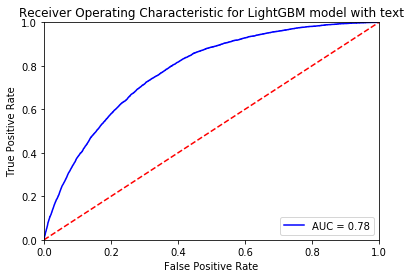

Confusion matrix:
 [[45327 23211]
 [ 1539  4761]]


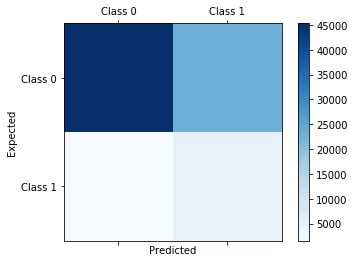

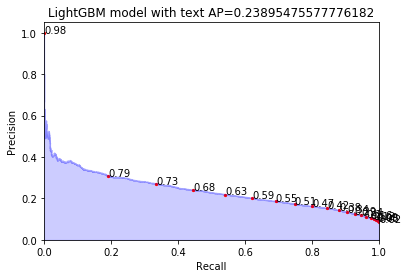

In [51]:
evaluate_model(lgbmodel, X_test, y_test, "LightGBM model with text")

### SHAP values of the new text-enriched model

In [52]:
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


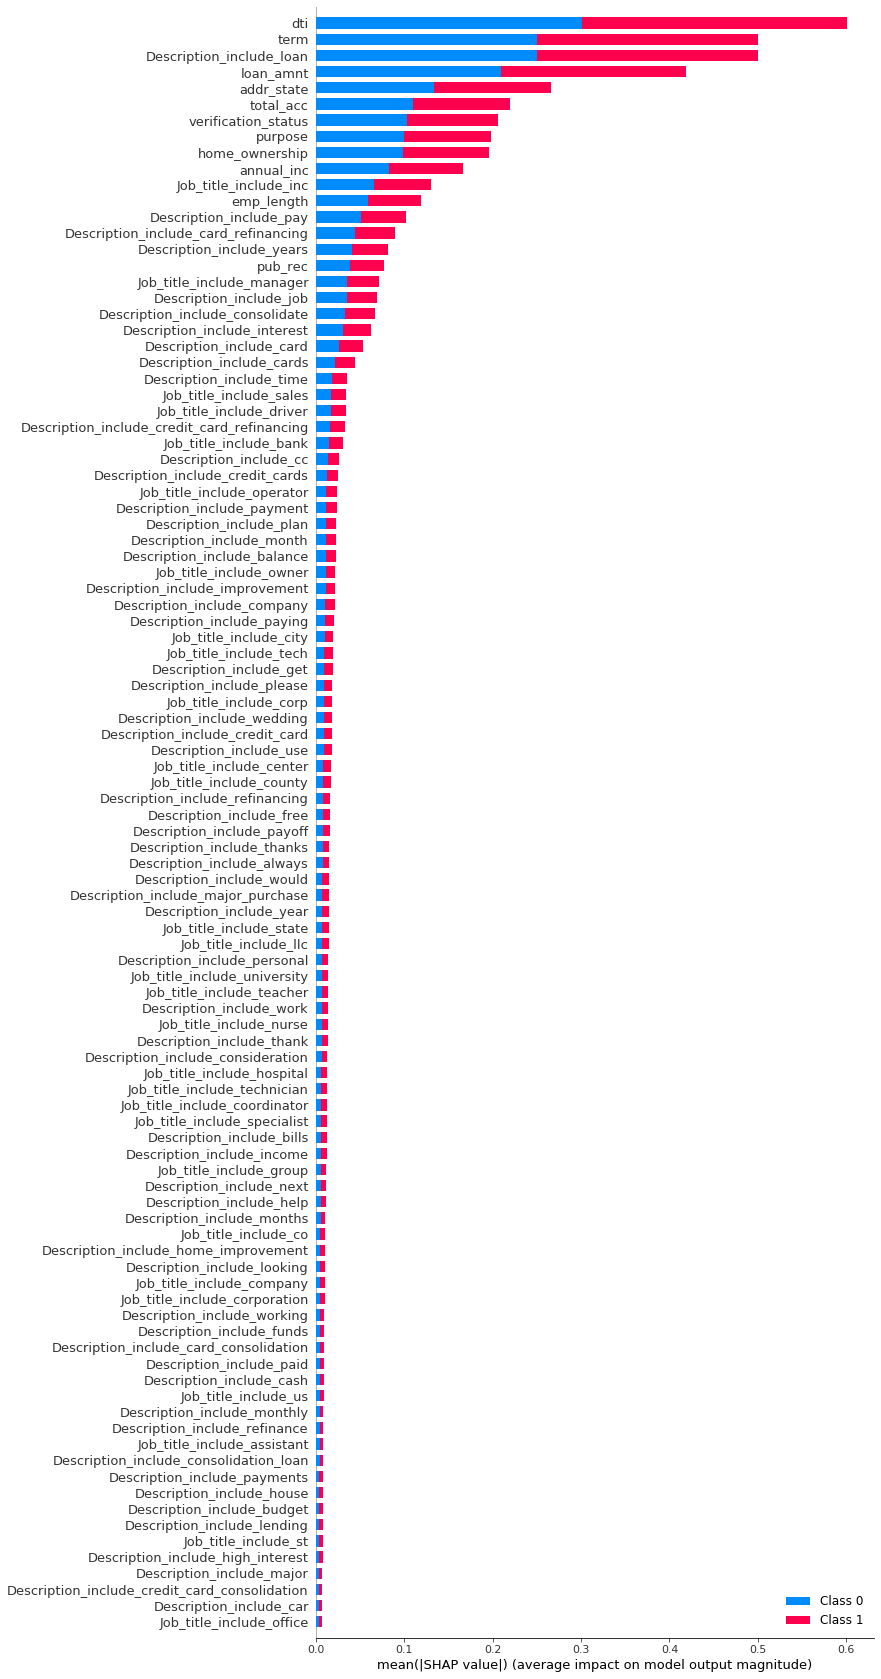

In [53]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,30), max_display=100)

In [54]:
scoring_data

,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,title,addr_state,dti,pub_rec,total_acc,bad_loan
0,3000.0,60 months,University Medical Group,1 year,RENT,80000.0,Source Verified,Borrower added on 12/21/11 > I plan on combi...,other,Personal,OR,17.94,0.0,38.0,NaN
1,7000.0,60 months,Southern Star Photography,8 years,RENT,47004.0,Not Verified,Borrower added on 12/18/11 > I am planning o...,debt_consolidation,Loan,NC,23.51,0.0,11.0,NaN
2,10000.0,60 months,US Legal Support,2 years,RENT,29120.0,Verified,NaN,debt_consolidation,Brown Eyes Loan,FL,22.83,0.0,31.0,NaN
3,12500.0,60 months,United States Infrastructure Corporation,1 year,RENT,27000.0,Verified,Borrower added on 12/20/11 > The purpose of ...,debt_consolidation,Credit card debt,IL,16.04,0.0,24.0,NaN
4,17500.0,60 months,NaN,6 years,RENT,40000.0,Verified,Borrower added on 11/28/11 > Thanks.<br> Bor...,small_business,Start Up,CA,19.47,0.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601333,10000.0,36 months,Office Assistant,8 years,RENT,31000.0,Verified,NaN,debt_consolidation,Debt consolidation,CA,28.69,1.0,15.0,NaN
601334,24000.0,36 months,Director of Maintenance,10+ years,MORTGAGE,79000.0,Verified,NaN,home_improvement,Home improvement,NJ,3.90,0.0,23.0,NaN
601335,13000.0,60 months,Radiologist Technologist,5 years,RENT,35000.0,Verified,NaN,debt_consolidation,Debt consolidation,TN,30.90,1.0,22.0,NaN
601336,12000.0,60 months,Painter,1 year,RENT,64400.0,Source Verified,NaN,debt_consolidation,Debt consolidation,MA,27.19,0.0,20.0,NaN


### best model setup

    LightGBM
    non-scaled numeric features
    naitively handles categorical features
    TF-representation (limit=200) of Title+desc and emp_title
    recall = 0.76
    precision = 0.19
    AUC = 0.78
    
    


### If this was a real project...

* More Feature engineering
* Hyperparameter tuning/tweaking the models
* cross-validation
* exploring more subsampling techniques
* stacking of models


### But now ... we deploy it! 

In [55]:
scoring_toolbox = {"model":lgbmodel,
                   "categorical_cols": categorical_cols,
                   "numeric_cols": numeric_cols,
                   "text_processing": (tf1, tf2), 
                   "col_order": X_new.columns}

In [56]:
pickle.dump(scoring_toolbox, open("scoring_toolbox.pkl", "wb"))

In [57]:
categorical_cols

5                    term
11             emp_length
12         home_ownership
14    verification_status
16            loan_status
20                purpose
23             addr_state
52       application_type
Name: Column name, dtype: object

### Fetch scoring data

In [58]:
scoring_data = pickle.load(open("scoring_data.pkl", "rb"))
scoring_data["data"].drop("bad_loan", axis=1,inplace=True)

### Define scoring script (can be executed anywhere)

In [59]:
def score_new_data(scoring_data,
                   model_toolbox, 
                   cutoff=0.5):

    scoring_df = scoring_data["data"].copy()


    drop_list=["loan_status", "application_type"]

    categorical_cols=model_toolbox["categorical_cols"]

    categorical_cols_list = [x for x in categorical_cols if x not in drop_list]

    numeric_cols=model_toolbox["numeric_cols"]
    tf1, tf2 = model_toolbox["text_processing"]
    model = model_toolbox["model"]
    col_order=model_toolbox["col_order"]

    scoring_df = fill_nans(scoring_df)

    scoring_df[categorical_cols_list] = clean_categorical_values(scoring_df[categorical_cols_list]).astype("category")

    textfield_1 = scoring_df["desc"] + ' ' + scoring_df["title"]
    textfield_2 = scoring_df["emp_title"]

    textfield_1 = clean_categorical_values(textfield_1, rep=' ', rx='[^a-zA-Z]+')
    textfield_2 = clean_categorical_values(textfield_2, rep=' ', rx='[^a-zA-Z]+')

    df_text1 = tf1.transform(textfield_1, id_str="Description_include_")
    df_text2 = tf2.transform(textfield_2, id_str="Job_title_include_")
    
    X_new = (scoring_df.reset_index(drop=True)
         .merge(df_text1.reset_index(drop=True), 
                left_index=True, right_index=True)
         .merge(df_text2.reset_index(drop=True), 
                left_index=True, right_index=True))
    
    ids = scoring_data['loan_ids']
    return_df = pd.DataFrame()
    return_df["LoanID"]=ids
    return_df["Confidence"] = model.predict(X_new[col_order])
    return_df["Default"] = ["Yes" if x > cutoff else "No" for x in return_df["Confidence"]]
    return return_df


### Score

In [60]:
open_loan_scorings = score_new_data(scoring_data, scoring_toolbox)

print(f"Number of loans scored: {open_loan_scorings.shape[0]}")

'copy' param is unused and has been deprecated since version 0.22. Backward compatibility for 'copy' will be removed in 0.24.


Number of loans scored: 601338


In [61]:
open_loan_scorings.head(20)

,LoanID,Confidence,Default
0,1075358,0.024653,No
1,1069639,0.115901,No
2,1065420,0.616071,Yes
3,1069346,0.240419,No
4,1068934,0.282503,No
5,1063958,0.392086,No
6,1068575,0.449429,No
7,1067874,0.031782,No
8,1034693,0.196291,No
9,1067654,0.430973,No


In [62]:
open_loan_scorings.sort_values(by=["Confidence"], ascending=False).head(20)

,LoanID,Confidence,Default
379335,58301084,0.983981,Yes
501684,46886468,0.975653,Yes
486945,48626951,0.972912,Yes
313465,62247433,0.972702,Yes
339496,61037374,0.972701,Yes
510936,43369831,0.972504,Yes
466158,50555655,0.969410,Yes
424710,55260309,0.969122,Yes
98189,32188498,0.968819,Yes
544334,42663132,0.968800,Yes


### Outline of the project

Data filtering and feature selection

Data visualization

Prepare data for modeling

Modeling
* Linear model etc
* Boosting models

* Adding Text

Define how to put it into production 